In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import tqdm.notebook as tqdm
import gtsam
from gtsam.symbol_shorthand import X, P
from IPython.display import HTML

import loader
import sln_fit
from fit_types import OptimizationLoggingParams
import utils
from utils import Point2_, Double_
from art_skills import SlnStrokeExpression2

%load_ext autoreload
%autoreload 2

In [2]:
letter_data = loader.load_segments('A', index=None)
print(f'total letter duration is approx {sum(traj[-1][-1, 0] for traj in letter_data):.5f}s')

total letter duration is approx 2.04167s


# ISAM2 with 1 stroke

Note: this doesn't actually really take advantage of ISAM at all, since there's only 1 variable.

But at least we can learn the mechanics of ISAM.

In [3]:
# Do an incremental solve on just 1 stroke
# Configure
isam2params = gtsam.ISAM2Params()
isam2params.evaluateNonlinearError = True
isam2params.relinearizeSkip = 1
fit_params = sln_fit.FitStrokeParams()
logging_params = OptimizationLoggingParams(print_progress=False)
strokedata = iter(letter_data[0][0])
# Initialize
isam = gtsam.ISAM2(isam2params)
strokei = 0
k = 0
history = []
stroke = SlnStrokeExpression2(P(strokei))

# Run
with utils.Time('Incremental Solve') as t:
    # stroke needs to start with some amount of data
    graph = gtsam.NonlinearFactorGraph()
    for datai in range(10):
        graph.add(sln_fit.create_factor(*next(strokedata), stroke, fit_params, strokei))
        k += 1
    init = gtsam.Values()
    init.insert(P(strokei), np.array([letter_data[0][strokei][0, 0] - 0.05, 1., 0., 0., 0.5, -0.5]))
    init.insert(X(strokei), letter_data[0][strokei][0, 1:])
    init, _ = utils.solve(graph, init, fit_params.lm_params, logging_params)
    history.append((isam.update(graph, init), k,
                    sln_fit.StrokeUtils.values2solution(isam.calculateBestEstimate(), stroke,
                                                        letter_data[0][strokei], strokei)))
    print(f'Initialization (t <= {letter_data[0][strokei][datai, 0]}) took {t()} seconds')
    # Now do incremental
    for datapoint in strokedata:
        k += 1
        graph = gtsam.NonlinearFactorGraph()
        graph.add(sln_fit.create_factor(*datapoint, stroke, fit_params, strokei))
        isam.update(graph, gtsam.Values())
        for _ in range(3):
            isam.update()
        history.append((isam.update(), k,
                        sln_fit.StrokeUtils.values2solution(isam.calculateBestEstimate(), stroke,
                                                            letter_data[0][strokei], strokei)))

Initialization (t <= 0.075) took 0.03999838099844055 seconds
Incremental Solve took 0.07895 seconds


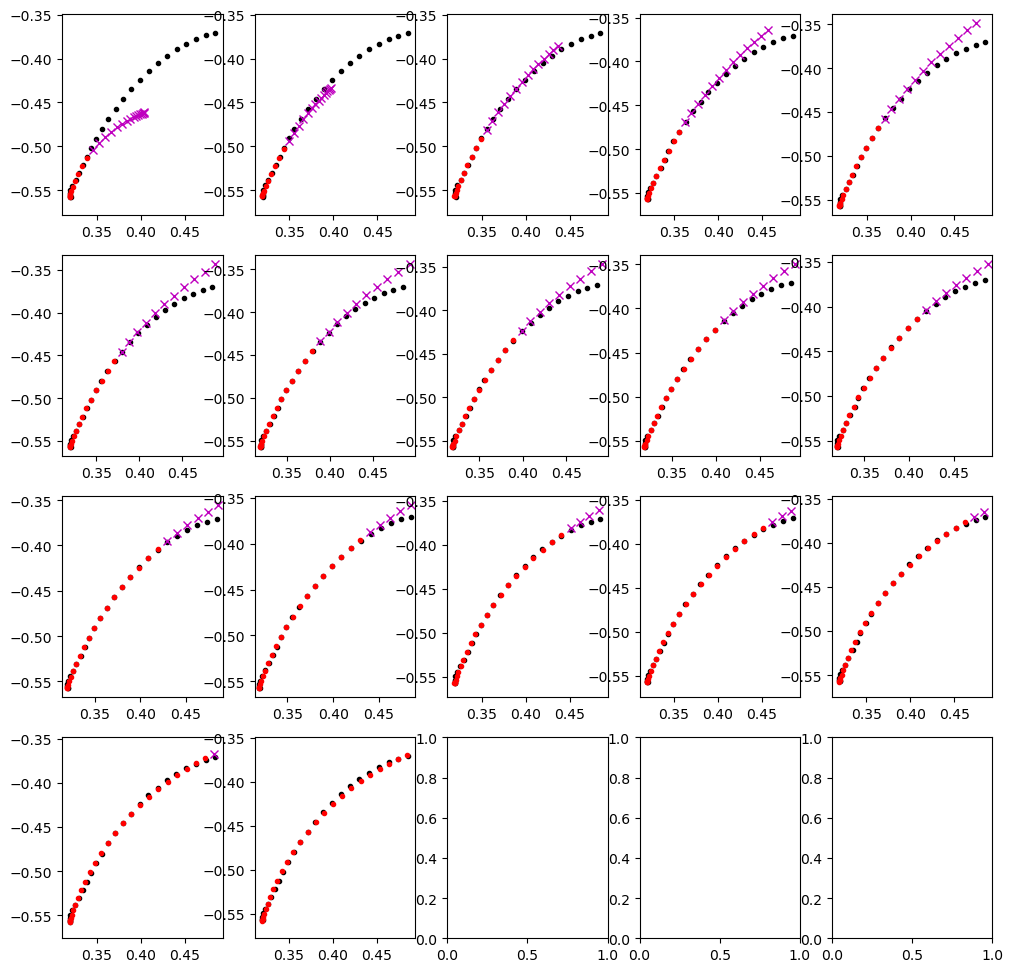

In [4]:
# Plot results
rows = int(np.sqrt(len(history)))
cols = len(history) // rows + 1
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
axes = axes.flatten()
for (_, k, est), ax in zip(history, axes):
    ax.plot(est['data'][:, 1], est['data'][:, 2], 'k.')
    ax.plot(est['txy'][:k, 1], est['txy'][:k, 2], 'r.')
    ax.plot(est['txy'][k:, 1], est['txy'][k:, 2], 'mx')
    ax.axis('equal')

# How to handle multiple strokes

Initially I tried just doing the way we have been doing, e.g.:
```
data[0] = x0 + eval(p0, t = 0)
data[1] = x0 + eval(p0, t = 1)
data[2] = x0 + eval(p0, t = 2)
data[3] = x1 + eval(p1, t = 3)
data[4] = x1 + eval(p1, t = 4)
data[5] = x1 + eval(p1, t = 5)
data[6] = x2 + eval(p2, t = 6)
data[7] = x2 + eval(p2, t = 7)
data[8] = x2 + eval(p2, t = 8)
```

But this was causing issues.  Specifically, the strokes would get centered (t0) at really far away times so that the actual used part of the stroke was very sensitive to numerical difficulties and poorly conditioned.  (Note: I also might have had a bug in initializing t0, but since I deleted the multi-stroke code, I can't remember anymore.)

So I realized that probably we need to add the strokes properly.  This will help since, if e.g. stroke1 tries to start earlier, then it will mess up stroke0.  So if we add strokes properly, then the strokes should naturally avoid these types of conditioning problems.

I think there are 4 natural steps to take:
1. Add every stroke for every data point, and use full re-solving (with warm-starts)
2. Add every stroke for every data point, and use marginalization to get rid of old strokes
3. Discard when stroke contributions are very small (only keep the small overlaps), and full re-solving (with warm-starts)
4. Discard when stroke contributions are very small (only keep the small overlaps), and use ISAM2.

To clarify, 1 and 2 are like:
```
data[0] = x0 + eval(p0, t = 0) + eval(p1, t = 0) + eval(p2, t = 0)
data[1] = x0 + eval(p0, t = 1) + eval(p1, t = 1) + eval(p2, t = 1)
data[2] = x0 + eval(p0, t = 2) + eval(p1, t = 2) + eval(p2, t = 2)
data[3] = x0 + eval(p0, t = 3) + eval(p1, t = 3) + eval(p2, t = 3)
data[4] = x0 + eval(p0, t = 4) + eval(p1, t = 4) + eval(p2, t = 4)
data[5] = x0 + eval(p0, t = 5) + eval(p1, t = 5) + eval(p2, t = 5)
...
```

Whereas 3 and 4 are like:
...TODO...
The scheme we will use is to keep a list of all the strokes, but when a stroke gets "small" (the contribution is small), then we will "freeze" the contributions.  i.e.
data[0] = x0 + eval(p0, t = 0)
data[1] = x0 + eval(p0, t = 1)
data[2] = x0 + eval(p0, t = 2)
data[3] = x0 + eval(p0, t = 3)
data[4] = x0 + eval(p0, t = 4) + eval(p1, t = 5)

data[0] = x0 + eval(p0, t = 0)
data[1] = x0 + eval(p0, t = 1)
data[2] = x0 + eval(p0, t = 2)
data[3] = x0 + eval(p0, t = 3)
data[3] = x0 + eval(p0, t = 3)
data[3] = x0 + eval(p0, t = 3)
```



The scheme we will use is to keep a list of all the strokes, but when a stroke gets "small" (the contribution is small), then we will "freeze" the contributions.  i.e.
data[0] = x0 + eval(p0, t = 0)
data[1] = x0 + eval(p0, t = 1)
data[2] = x0 + eval(p0, t = 2)
data[3] = x0 + eval(p0, t = 3)
data[4] = x0 + eval(p0, t = 4) + eval(p1, t = 5)

# 1. Every stroke contributes to every point: Full Re-solving using warm-starts (No ISAM2)

In [5]:
# Util
def create_graph(data, strokes):
    graph = gtsam.NonlinearFactorGraph()
    for t, x, y in data:
        graph.add(sln_fit.create_factor2(t, x, y, strokes, fit_params))
    return graph

In [6]:
# Setup
traj_data = np.concatenate([stroke for stroke in letter_data[0]])
inds_to_add_stroke = np.array([0] +
                              np.cumsum([stroke.shape[0] for stroke in letter_data[0]]).tolist())
strokes = []
strokei = 0
history = []
init = gtsam.Values()
init.insert(X(strokei), traj_data[0, 1:])
fit_params.lm_params.setRelativeErrorTol(1e-5)
fit_params.lm_params.setMaxIterations(3)

# Run
with utils.Time('Incremental Solve') as t:
    # for k in tqdm.trange(100):
    for k in tqdm.trange(traj_data.shape[0]):
        if k == inds_to_add_stroke[strokei]:
            strokes.append(SlnStrokeExpression2(P(strokei)))
            if strokei == 0:
                init.insert(P(strokei), np.array([traj_data[k, 0] - 0.05, 1., 0., 0., 0.5, -0.5]))
            else:
                p = init.atVector(P(strokei - 1))
                init.insert(P(strokei),
                            np.array([traj_data[k, 0] - 0.05, 1., p[3], p[3], 0.5, -0.5]))
            strokei += 1
        if k < 10:
            continue
        # if k % 3 < 2:
        #     continue
        init, _ = utils.solve(create_graph(traj_data[:k], strokes), init, fit_params.lm_params,
                              logging_params)
        # init, _ = utils.solve(create_graph(traj_data[:k], strokes), init, fit_params.lm_params)
        history.append((k, gtsam.Values(init), t()))

  0%|          | 0/211 [00:00<?, ?it/s]

Incremental Solve took 13.15909 seconds


[  0  26  76  90 103 146 165 184 197 211]


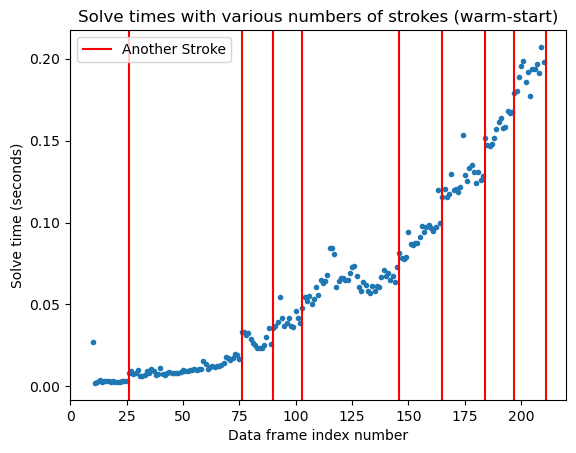

In [7]:
times = [0] + [t for _, _, t in history]
plt.plot([k for k, _, _ in history], np.diff(times), '.')
print(inds_to_add_stroke)
for ind in inds_to_add_stroke:
    plt.axvline(ind, color='r', label='Another Stroke' if ind == 0 else None)
plt.title('Solve times with various numbers of strokes (warm-start)')
plt.xlabel('Data frame index number')
plt.ylabel('Solve time (seconds)')
plt.legend()

In [8]:
# Util to convert Values to txy
ts = traj_data[:, 0]
xy = lambda t, est, strokes: sum((stroke.pos(t, True, np.zeros(2), est) for stroke in strokes),
                                 Point2_(X(0)).value(est))
speed = lambda t, est, strokes: sum(stroke.speed(t, True, est) for stroke in strokes)
xys = []
speeds = []
for k, est, _ in history[::11]:
    # xys.append(np.array([xy(t, est, strokes[:sum(k > inds_to_add_stroke)]) for t in ts[:k]]))
    xys.append((k, np.array([xy(t, est, strokes[:sum(k > inds_to_add_stroke)]) for t in ts])))
    # speeds.append(np.array([speed(t, est, strokes[:sum(k > inds_to_add_stroke)]) for t in ts[:k]]))
    speeds.append(np.linalg.norm(np.diff(xys[-1][1][:k, :], axis=0), axis=1) * 120)
speed_gt = np.linalg.norm(np.diff(traj_data[:, 1:], axis=0), axis=1) * 120

Text(0.5, 0.98, 'Incremental Solve (warm-start)')

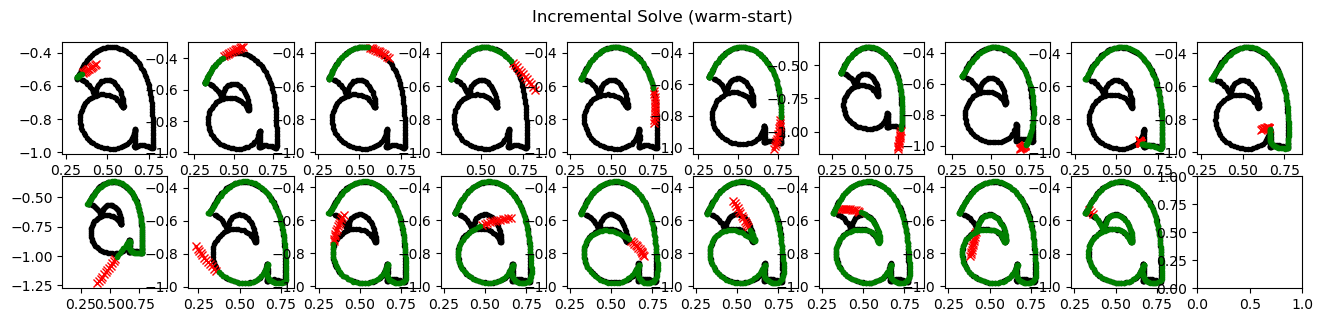

In [9]:
# Plot xy
fig, axes = plt.subplots(len(xys) // 10 + 1, 10, figsize=(16, (len(xys) // 10 + 1) * 1.6))
for ax, (k, xy) in zip(axes.flatten(), xys):
    ax.plot(traj_data[:, 1], traj_data[:, 2], 'k.')
    ax.plot(xy[k:k + 12, 0], xy[k:k + 12, 1], 'rx')
    ax.plot(xy[:k, 0], xy[:k, 1], 'g.')
    ax.axis('equal')
plt.suptitle('Incremental Solve (warm-start)')

Text(0.5, 0.98, 'Incremental Solve (warm-start): Speed')

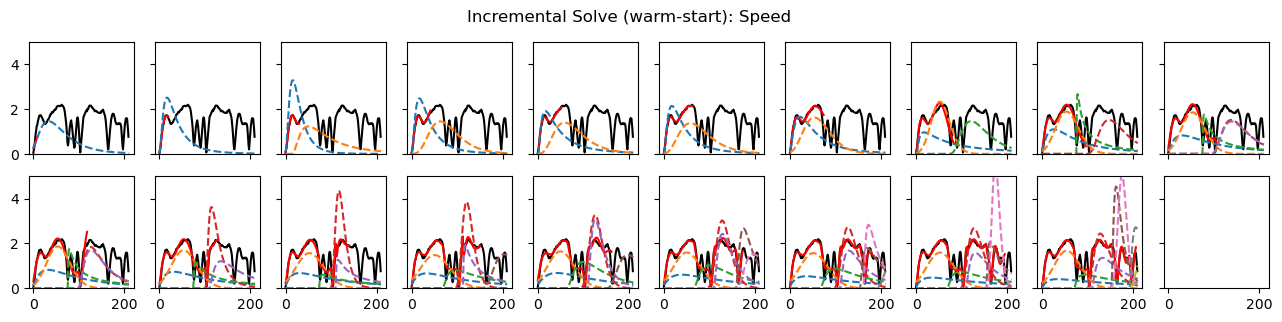

In [10]:
# Plot speed
fig, axes = plt.subplots(len(xys) // 10 + 1,
                         10,
                         figsize=(16, (len(xys) // 10 + 1) * 1.6),
                         sharex=True,
                         sharey=True)
for ax, speed in zip(axes.flatten(), speeds):
    ax.plot(speed_gt, 'k')
    ax.plot(speed, 'r')
for (k, est, _), ax in zip(history[::11], axes.flatten()):
    strokes_ = strokes[:sum(k > inds_to_add_stroke)]
    ax.plot(np.array([[stroke.speed(t, True, est) for stroke in strokes_] for t in ts]), '--')
axes[0, 0].set_ylim(0, 5)
plt.suptitle('Incremental Solve (warm-start): Speed')

# 2. Every stroke contributes to every point: Marginalization (No ISAM2)

In [ ]:
# Setup
traj_data = np.concatenate([stroke for stroke in letter_data[0]])
inds_to_add_stroke = np.array([0] +
                              np.cumsum([stroke.shape[0] for stroke in letter_data[0]]).tolist())
strokes = []
strokei = 0
history = []
init = gtsam.Values()
init.insert(X(strokei), traj_data[0, 1:])
fit_params.lm_params.setRelativeErrorTol(1e-5)
fit_params.lm_params.setMaxIterations(3)

# Run
with utils.Time('Incremental Solve') as t:
    # for k in tqdm.trange(100):
    for k in tqdm.trange(traj_data.shape[0]):
        if k == inds_to_add_stroke[strokei]:
            strokes.append(SlnStrokeExpression2(P(strokei)))
            if strokei == 0:
                init.insert(P(strokei), np.array([traj_data[k, 0] - 0.05, 1., 0., 0., 0.5, -0.5]))
            else:
                p = init.atVector(P(strokei - 1))
                init.insert(P(strokei),
                            np.array([traj_data[k, 0] - 0.05, 1., p[3], p[3], 0.5, -0.5]))
            if strokei > 1:
                p = init.atVector(P(strokei - 2))
                strokes[strokei - 2] = SlnStrokeExpression2(p)
                init.erase(P(strokei - 2))
            strokei += 1
        if k < 10:
            continue
        fit_params.lm_params.setMaxIterations(100)
        if k > 10:
            fit_params.lm_params.setMaxIterations(3)
        # if k % 3 < 2:
        #     continue
        init, _ = utils.solve(create_graph(traj_data[:k], strokes), init, fit_params.lm_params,
                              logging_params)
        # init, _ = utils.solve(create_graph(traj_data[:k], strokes), init, fit_params.lm_params)
        history.append((k, gtsam.Values(init), t()))

In [ ]:
times = [0] + [t for _, _, t in history]
plt.plot([k for k, _, _ in history], np.diff(times), '.')
print(inds_to_add_stroke)
for ind in inds_to_add_stroke:
    plt.axvline(ind, color='r', label='Another Stroke' if ind == 0 else None)
plt.title('Solve times with various numbers of strokes (warm-start)')
plt.xlabel('Data frame index number')
plt.ylabel('Solve time (seconds)')
plt.legend()

In [ ]:
# Util to convert Values to txy
ts = traj_data[:, 0]
xy = lambda t, est, strokes: sum((stroke.pos(t, True, np.zeros(2), est) for stroke in strokes),
                                 Point2_(X(0)).value(est))
speed = lambda t, est, strokes: sum(stroke.speed(t, True, est) for stroke in strokes)
xys = []
speeds = []
for k, est, _ in history[::11]:
    # xys.append(np.array([xy(t, est, strokes[:sum(k > inds_to_add_stroke)]) for t in ts[:k]]))
    xys.append((k, np.array([xy(t, est, strokes[:sum(k > inds_to_add_stroke)]) for t in ts])))
    # speeds.append(np.array([speed(t, est, strokes[:sum(k > inds_to_add_stroke)]) for t in ts[:k]]))
    speeds.append(np.linalg.norm(np.diff(xys[-1][1][:k, :], axis=0), axis=1) * 120)
speed_gt = np.linalg.norm(np.diff(traj_data[:, 1:], axis=0), axis=1) * 120

In [ ]:
# Plot xy
fig, axes = plt.subplots(len(xys) // 10 + 1, 10, figsize=(16, (len(xys) // 10 + 1) * 1.6))
for ax, (k, xy) in zip(axes.flatten(), xys):
    ax.plot(traj_data[:, 1], traj_data[:, 2], 'k.')
    ax.plot(xy[k:k + 12, 0], xy[k:k + 12, 1], 'rx')
    ax.plot(xy[:k, 0], xy[:k, 1], 'g.')
    ax.axis('equal')
plt.suptitle('Incremental Solve (warm-start)')

In [ ]:
# Plot speed
fig, axes = plt.subplots(len(xys) // 10 + 1,
                         10,
                         figsize=(16, (len(xys) // 10 + 1) * 1.6),
                         sharex=True,
                         sharey=True)
for ax, speed in zip(axes.flatten(), speeds):
    ax.plot(speed_gt, 'k')
    ax.plot(speed, 'r')
for (k, est, _), ax in zip(history[::11], axes.flatten()):
    strokes_ = strokes[:sum(k > inds_to_add_stroke)]
    ax.plot(np.array([[stroke.speed(t, True, est) for stroke in strokes_] for t in ts]), '--')
axes[0, 0].set_ylim(0, 5)
plt.suptitle('Incremental Solve (warm-start): Speed')

# 2.a: Trimming out some computational fat

In [ ]:
# Util
def create_graph_2(kstart, kend, data, strokes, previous_contributions=None):
    graph = gtsam.NonlinearFactorGraph()
    if not np.any(previous_contributions):
        for t, x, y in data[kstart:kend]:
            graph.add(sln_fit.create_factor2(t, x, y, strokes, fit_params, x0=Point2_(X(0))))
    else:
        for (t, x, y), contrib in zip(data[kstart:kend], previous_contributions[kstart:kend]):
            graph.add(sln_fit.create_factor2(t, x, y, strokes, fit_params, x0=Point2_(contrib)))
    return graph

In [ ]:
# Setup
traj_data = np.concatenate([stroke for stroke in letter_data[0]])
inds_to_add_stroke = np.array([0] +
                              np.cumsum([stroke.shape[0] for stroke in letter_data[0]]).tolist())
strokes = [SlnStrokeExpression2(P(0))]
stroke_bndis = [0, 1]
history = []
init = gtsam.Values()
init.insert(X(0), traj_data[0, 1:])
init.insert(P(0), np.array([traj_data[0, 0] - 0.05, 1., 0., 0., 0.5, -0.5]))
fit_params.lm_params.setRelativeErrorTol(1e-5)
fit_params.lm_params.setMaxIterations(3)
previous_contributions = np.zeros((traj_data.shape[0], 2))

# Run
with utils.Time('Incremental Solve') as t:
    init, _ = utils.solve(create_graph(traj_data[:10], strokes), init,
                          utils.create_params(relativeErrorTol=0, absoluteErrorTol=1e-10),
                          logging_params)
    # for k in tqdm.trange(100):
    for k in tqdm.trange(10, traj_data.shape[0]):
        if k == inds_to_add_stroke[stroke_bndis[1]]:
            # add new stroke
            strokes.append(SlnStrokeExpression2(P(stroke_bndis[1])))
            p = init.atVector(P(stroke_bndis[1] - 1))
            init.insert(P(stroke_bndis[1]),
                        np.array([traj_data[k, 0] - 0.05, 1., p[3], p[3], 0.5, -0.5]))
            # marginalize-out x0
            if stroke_bndis[1] == 2:
                previous_contributions += init.atPoint2(X(0))
                print(strokes[stroke_bndis[0]].pos(traj_data[k, 0], values=init))
                init.erase(X(0))
            # marginalize-out old stroke
            if stroke_bndis[1] > 1:
                stroke = strokes[stroke_bndis[0]]
                previous_contributions += np.array(
                    [stroke.pos(t, values=init) for t in traj_data[:, 0]])
                strokes[stroke_bndis[0]] = None  # assert-like statement
                init.erase(P(stroke_bndis[0]))
                stroke_bndis[0] += 1
            stroke_bndis[1] += 1
        # fit_params.lm_params.setMaxIterations(100)
        # if k > 10:
        #     fit_params.lm_params.setMaxIterations(3)
        # if k % 3 < 2:
        #     continue
        kstart = inds_to_add_stroke[stroke_bndis[0]]
        graph = create_graph_2(kstart,
                               k + 1,
                               traj_data,
                               strokes[stroke_bndis[0]:stroke_bndis[1]],
                               previous_contributions=previous_contributions)
        init, _ = utils.solve(graph, init, fit_params.lm_params, logging_params)
        # init, _ = utils.solve(create_graph(traj_data[:k], strokes), init, fit_params.lm_params)
        history.append((k, (gtsam.Values(init), tuple(stroke_bndis), previous_contributions*1), t()))

In [ ]:
times = [0] + [t for _, _, t in history]
plt.plot([k for k, _, _ in history], np.diff(times), '.')
print(inds_to_add_stroke)
for ind in inds_to_add_stroke:
    plt.axvline(ind, color='r', label='Another Stroke' if ind == 0 else None)
plt.title('Solve times with various numbers of strokes (warm-start)')
plt.xlabel('Data frame index number')
plt.ylabel('Solve time (seconds)')
plt.legend()

In [ ]:
# Util to convert Values to txy
strokes = [SlnStrokeExpression2(P(i)) for i in range(len(inds_to_add_stroke))]
ts = traj_data[:, 0]
xy = lambda t, est, strokes: sum(stroke.pos(t, values=est)
                                 for stroke in strokes) + (est.atPoint2(X(0))
                                                           if est.exists(X(0)) else np.zeros(2))
speed = lambda t, est, strokes: sum(stroke.speed(t, True, est) for stroke in strokes)
xys = []
speeds = []
for k, (est, (stroke_s, stroke_e), previous_contributions), _ in history[::11]:
    # xys.append(np.array([xy(t, est, strokes[:sum(k > inds_to_add_stroke)]) for t in ts[:k]]))
    xys.append(
        (k,
         np.array([xy(t, est, strokes[stroke_s:stroke_e]) for t in ts]) + previous_contributions))
    # speeds.append(np.array([speed(t, est, strokes[:sum(k > inds_to_add_stroke)]) for t in ts[:k]]))
    speeds.append(np.linalg.norm(np.diff(xys[-1][1][:k, :], axis=0), axis=1) * 120)
speed_gt = np.linalg.norm(np.diff(traj_data[:, 1:], axis=0), axis=1) * 120

In [ ]:
# Plot xy
fig, axes = plt.subplots(len(xys) // 10 + 1, 10, figsize=(16, (len(xys) // 10 + 1) * 1.6))
for ax, (k, xy) in zip(axes.flatten(), xys):
    ax.plot(traj_data[:, 1], traj_data[:, 2], 'k.')
    ax.plot(xy[k:k + 12, 0], xy[k:k + 12, 1], 'rx')
    for s, e in zip(inds_to_add_stroke, inds_to_add_stroke[1:]):
        if e >= k:
            break
        ax.plot(xy[s:e, 0], xy[s:e, 1], '.')
    ax.plot(xy[s:k, 0], xy[s:k, 1], '.')
    ax.axis('equal')
plt.suptitle('Incremental Solve (warm-start)')

# 2.b: same as above but with fixed-lag window

In [ ]:
# Parameters
data_skip = 2
solve_skip = 1

# Setup
traj_data = np.concatenate([stroke for stroke in letter_data[0]])[::data_skip]
inds_to_add_stroke = np.array([0] +
                              np.cumsum([stroke.shape[0] for stroke in letter_data[0]]).tolist()) // data_skip
strokes = [SlnStrokeExpression2(P(0))]
k = 10
lag = 75 // data_skip
history = []
init = gtsam.Values()
init.insert(X(0), traj_data[0, 1:])
init.insert(P(0), np.array([traj_data[0, 0] - 0.05, 1., 0., 0., 0.5, -0.5]))
fit_params.lm_params.setRelativeErrorTol(1e-5)
fit_params.lm_params.setMaxIterations(3)
previous_contributions = np.zeros((traj_data.shape[0], 2))

# Run
with utils.Time('Incremental Solve') as t:
    init, _ = utils.solve(create_graph(traj_data[max(0, k - lag):k], strokes), init,
                          utils.create_params(relativeErrorTol=0, absoluteErrorTol=1e-10),
                          logging_params)
    for k in tqdm.trange(k, traj_data.shape[0]):
        # add new stroke
        if k in inds_to_add_stroke:
            i = inds_to_add_stroke.tolist().index(k)
            strokes.append(SlnStrokeExpression2(P(i)))
            p = init.atVector(P(i - 1))
            init.insert(P(i), np.array([traj_data[k, 0] - 0.05, 1., p[3], p[3], 0.5, -0.5]))
        # marginalize-out x0
        if (k - lag) == inds_to_add_stroke[0]:
            previous_contributions += init.atPoint2(X(0))
            init.erase(X(0))
        # marginalize-out old stroke
        if (k - lag) in inds_to_add_stroke:
            i = inds_to_add_stroke.tolist().index(k - lag)
            previous_contributions += np.array(
                [strokes[0].pos(t, values=init) for t in traj_data[:, 0]])
            del strokes[0]
            init.erase(P(i))
        if k % solve_skip > 0:
            continue
        graph = create_graph_2(max(0, k - lag),
                               k + 1,
                               traj_data,
                               strokes,
                               previous_contributions=previous_contributions)
        init, _ = utils.solve(graph, init, fit_params.lm_params, logging_params)
        # init, _ = utils.solve(create_graph(traj_data[:k], strokes), init, fit_params.lm_params)
        history.append(
            (k, (gtsam.Values(init), tuple(stroke_bndis), previous_contributions * 1), t()))


In [ ]:
times = [0] + [t for _, _, t in history]
plt.plot([k for k, _, _ in history], np.diff(times), '.')
print(inds_to_add_stroke)
for ind in inds_to_add_stroke:
    plt.axvline(ind, color='r', label='Another Stroke' if ind == 0 else None)
plt.title('Solve times with various numbers of strokes (warm-start)')
plt.xlabel('Data frame index number')
plt.ylabel('Solve time (seconds)')
plt.legend()

In [ ]:
# Util to convert Values to txy
strokes = [SlnStrokeExpression2(P(i)) for i in range(len(inds_to_add_stroke))]
ts = traj_data[:, 0]
get_strokes = lambda est: set(map(lambda k: strokes[k % 256], est.keys()))
xy = lambda t, est: sum((stroke.pos(t, values=est) for stroke in get_strokes(est)),
                        est.atPoint2(X(0)) if est.exists(X(0)) else np.zeros(2))
xys = []
speeds = []
for k, (est, (stroke_s, stroke_e), previous_contributions), _ in history[::1]:
    xys.append((k, np.array([xy(t, est) for t in ts]) + previous_contributions))
    speeds.append(np.linalg.norm(np.diff(xys[-1][1][:k, :], axis=0), axis=1) * 120)
speed_gt = np.linalg.norm(np.diff(traj_data[:, 1:], axis=0), axis=1) * 120

In [ ]:
# Plot xy
future_time = 0.05
future_inds = int(future_time * 120 / data_skip)
fig, axes = plt.subplots(len(xys) // 10 + 1, 10, figsize=(16, (len(xys) // 10 + 1) * 1.6))
for ax, (k, xy) in zip(axes.flatten(), xys):
    ax.plot(traj_data[:, 1], traj_data[:, 2], 'k.')
    ax.plot(xy[k:k + future_inds, 0], xy[k:k + future_inds, 1], 'rx', markersize=8)
    for s, e in zip(inds_to_add_stroke, inds_to_add_stroke[1:]):
        if e >= k:
            break
        ax.plot(xy[s:e, 0], xy[s:e, 1], '.', markersize=3)
    ax.plot(xy[s:k, 0], xy[s:k, 1], '.', markersize=3)
    ax.axis('equal')
plt.suptitle('Incremental Solve (warm-start)')

In [ ]:
fig, ax = plt.subplots()


def func(frame):
    k, xy = xys[frame]
    ax.cla()
    ax.plot(traj_data[:, 1], traj_data[:, 2], 'k.')
    ax.plot(xy[k:k + future_inds, 0], xy[k:k + future_inds, 1], 'rx', markersize=8)
    for s, e in zip(inds_to_add_stroke, inds_to_add_stroke[1:]):
        if e >= k:
            break
        ax.plot(xy[s:e, 0], xy[s:e, 1], '.', markersize=3)
    ax.plot(xy[s:k, 0], xy[s:k, 1], '.', markersize=3)
    ax.axis('equal')
    ax.set_ylim(-1.2, -0.3)


anim = FuncAnimation(fig, func, frames=len(xys), interval=1000. / 120 * data_skip)
anim.save('gerry11_incremental_marginalize_fixedlag_quarter_speed.mp4', fps=120 // data_skip // 4)
HTML(anim.to_jshtml())